### Diffusion Measurement 5
    Titanium Thickness 0.8mm

In [2]:
import numpy as np
# import diffusion_analysis_package as dap
# import importlib
# importlib.reload(dap)

In [2]:
class DictX(dict):
    # Author: Joseph Street
    # Date created: ~ 2020
    # Description: Converts a global variables (from hConfig.py, for example)
    #              to a dictionary (such that those variables can be assigned new values).
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError as k:
            raise AttributeError(k)

    def __setattr__(self, key, value):
        self[key] = value

    def __delattr__(self, key):
        try:
            del self[key]
        except KeyError as k:
            raise AttributeError(k)

    def __repr__(self):
        return '<DictX ' + dict.__repr__(self) + '>'

In [3]:
def setVariables():

    # DEFINING VARIABLE DICTIONARY (part 1/2)
    global vs
    keys_0 = dict(locals()).keys()
    
    # Measurement Specific Parameters
    measurementName = 'Measurement_5'
    tau_Rn = 5.516 # days
    tau_Rn_seconds = tau_Rn/24/3600 # seconds
    lamb_Rn = 1 / tau_Rn # decay constant [1/days]
    lamb_Rn_invSeconds = 1 / tau_Rn / 86400 # decay constant [1/seconds]
    mL_to_m3 = 1/1000 * 1/1000 
    
    # Event timestamps:
    start_of_hot_system_sampling = '2024-04-02 12:17:00' ###CHECK THIS TIME!!!
    start_of_diffusion  = '2024-03-27 12:13:00'
    end_of_diffusion = '2024-04-08 13:39:00'
    # start_of_noSource  = '2023-12-16 18:00:00' 
    
    # Technical
    post_fit_time_padding = 5 # day
    
    # Geometry (DOUBLE CHECK VALUES!)
    Vrad7 = 800
    Vtubing = 42 # !
    Vhot = 220 # mL - hot-side volume confirmed from diffusion note.
    Vsys = Vrad7 + Vtubing + Vhot # need to be checked for accuracy in mL
    
    V_coldSide_mL = Vrad7 + Vtubing + Vhot
    V_coldSide_m3 = V_coldSide_mL * mL_to_m3
    membrane_area_m2 = 0.00105 # m^2

    time_shift_sec = 30 * 60 # 30 minute shift to center readings and it at average of one hour bins
    
    
    # The Membrane
    membrane_thickness = 0.8 # mm
    membrane_thickness_m = membrane_thickness / 1e3 # m

    # DEFINING VARIABLE DICTIONARY (part 2/2)
    keys_1 = dict(locals()).keys()
    keys_to_keep = set(keys_1) - set(keys_0)
    vs = {k:locals()[k] for k in keys_to_keep}
    

    vs = DictX(vs)

# Define global variables
setVariables()

### Hot Side System Leak Rate
    Gets hot side system lambda

In [4]:
df = dap.getData('SDSMT', '240408_Ti_diff_hotSideSystem', binSize_hours=1/3, onlyPo218=True)
dfc = dap.placeCut(df, t_i='2024-04-06 00:00:00', t_f='2024-04-09 00:00:00') # timestamps from logs

ModuleNotFoundError: No module named 'Rad7_API'

Measurement folder already exists.
plot saved: Plots/Measurement_5/hotSide_with_selection.pdf


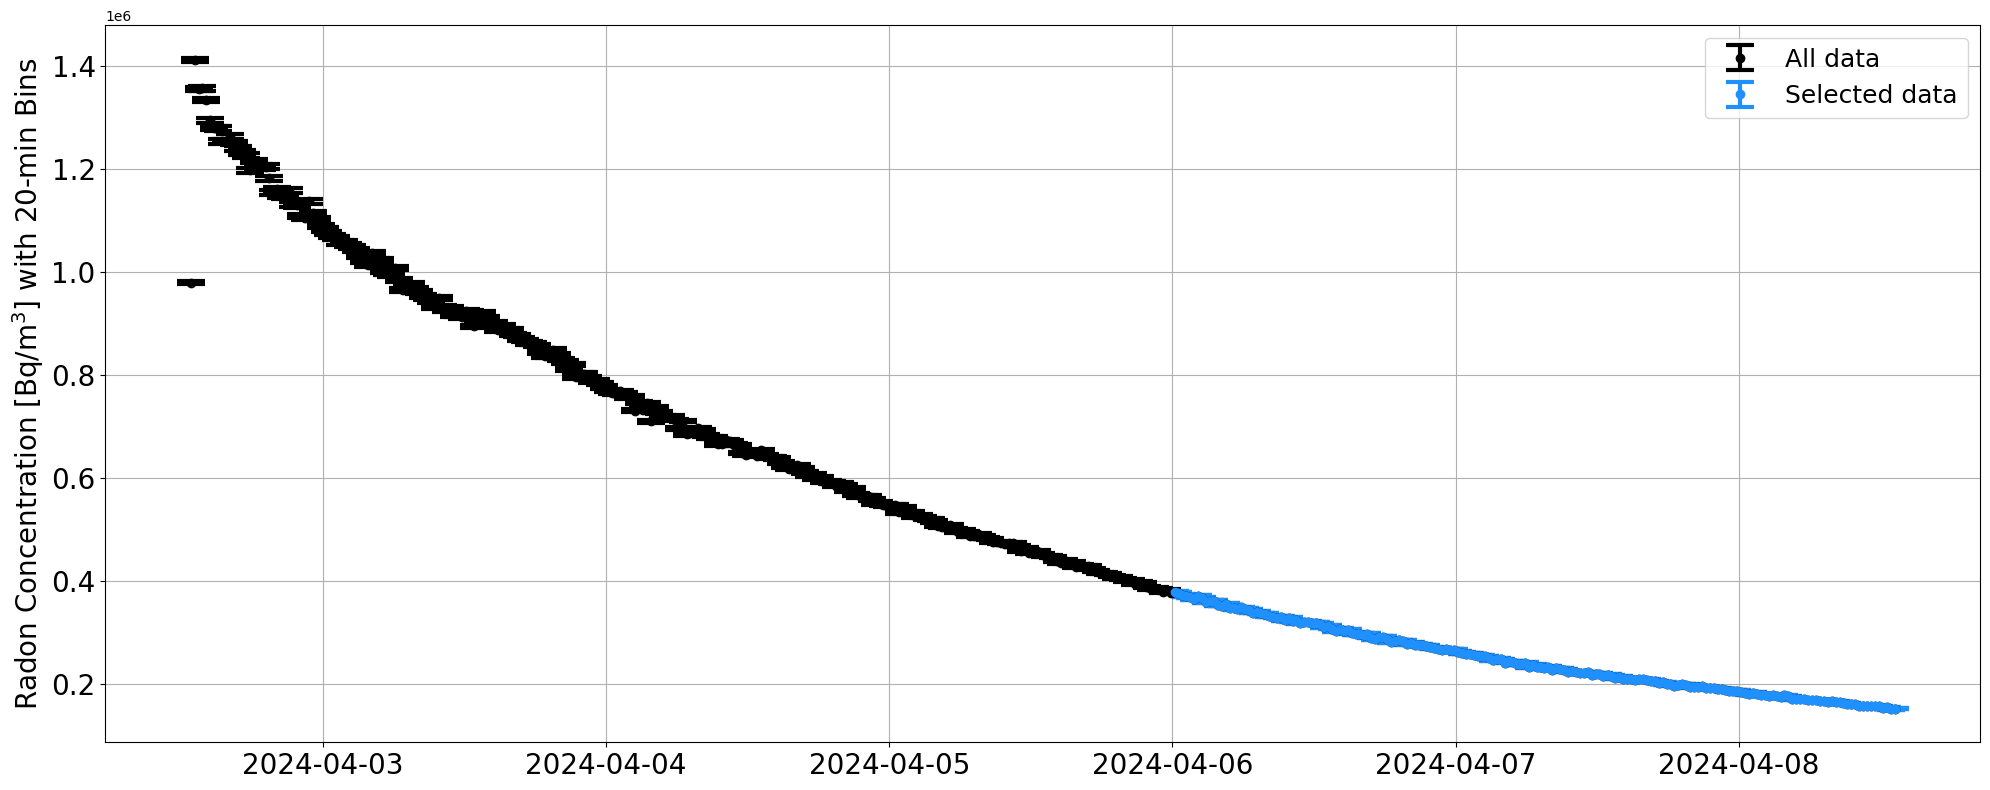

In [5]:
dap.getPlot(df, dfc=dfc, in_days=False, save_plot_as='hotSide_with_selection', measurementName=vs.measurementName)

In [7]:
#dap.getPlot_interactive(df,  xColumn='Days', yColumn='RnConc', errorColumn='Uncert_RnConc')

In [8]:
p0 = (max(dfc.RnConc), vs.tau_Rn, 0)
bounds = (0, np.infty)
ret = dap.performFit(dfc.Days, dfc.RnConc, dfc.Uncert_RnConc, p0=p0, bounds=bounds, fitting_function=dap.exponentialFit)


popt = [3.47974076e+05 2.44182041e+00 3.08140174e+04] +/- [3.12123687e+03 4.16722089e-02 3.49974871e+03]
pcov = [[ 9.74211958e+06  1.25558880e+02 -1.08171028e+07]
 [ 1.25558880e+02  1.73657300e-03 -1.44496525e+02]
 [-1.08171028e+07 -1.44496525e+02  1.22482410e+07]]
chi squared / ndf = 458.23 / 181 = 2.53, p-value = 0.000e+00


In [9]:
lamb_hot_system = 1 / ret['popt'][1]

Measurement folder already exists.
plot saved: Plots/Measurement_5/hotSide_with_selection_withFit.pdf


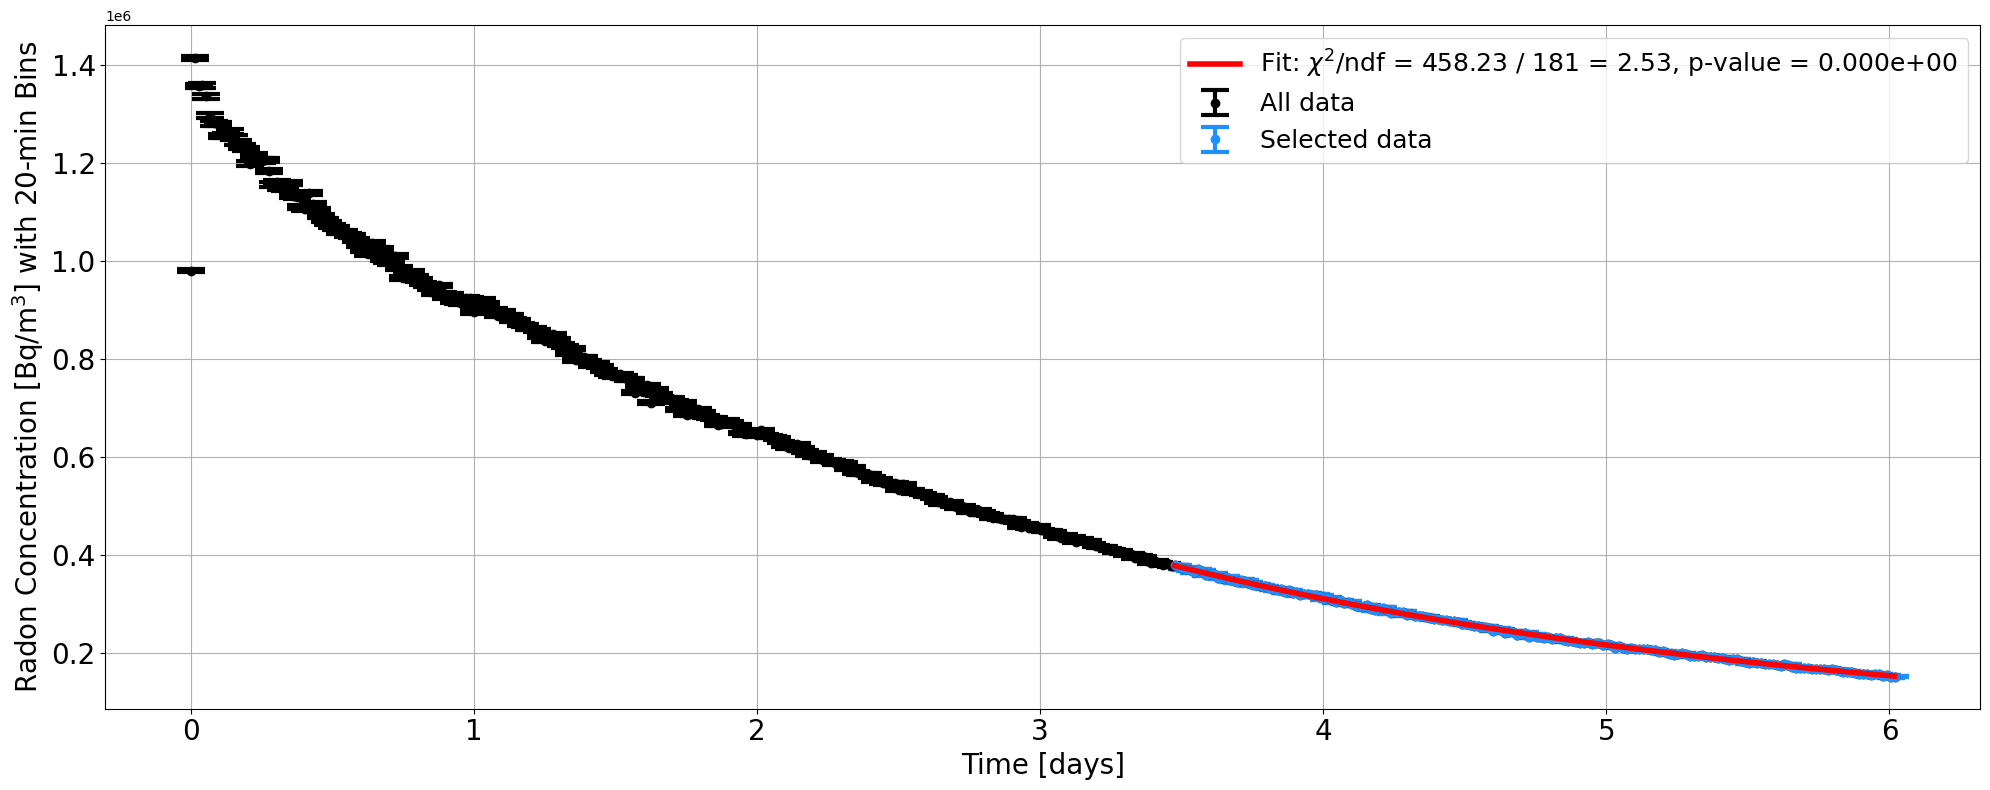

In [10]:
fit_plot_meta = {'x':dfc.Days, 'y':ret['fit'],'color':'r', 'lw':4,'label':'Fit: '+r'$\chi^2$/ndf = '+f"{ret['gof'][0]:0.2f} / {ret['gof'][1]:0.0f} = {ret['gof'][2]:0.2f}, p-value = {ret['gof'][3]:0.3e}"}
extra_curves=[fit_plot_meta]

dap.getPlot(df, dfc=dfc, in_days=True, save_plot_as='hotSide_with_selection_withFit', extra_curves=extra_curves, measurementName=vs.measurementName)

### Hot side extrapolation
    Gets intial hot side system concentration

In [11]:
import pandas as pd
# get time difference between start of dfc and hot-side system sampling
t_start = (dfc.DateTime.iloc[0] - pd.to_datetime(vs.start_of_hot_system_sampling)).total_seconds() / 86400

t_space = np.linspace(0, dfc.Days.iloc[-1] + vs.post_fit_time_padding, 1000) - t_start
fit_extended_to_start_of_sampling = ret['fitting_function'](t_space, *ret['popt'])


Measurement folder already exists.
plot saved: Plots/Measurement_5/hotSide_with_selection_withFit_andExtrapolation.pdf


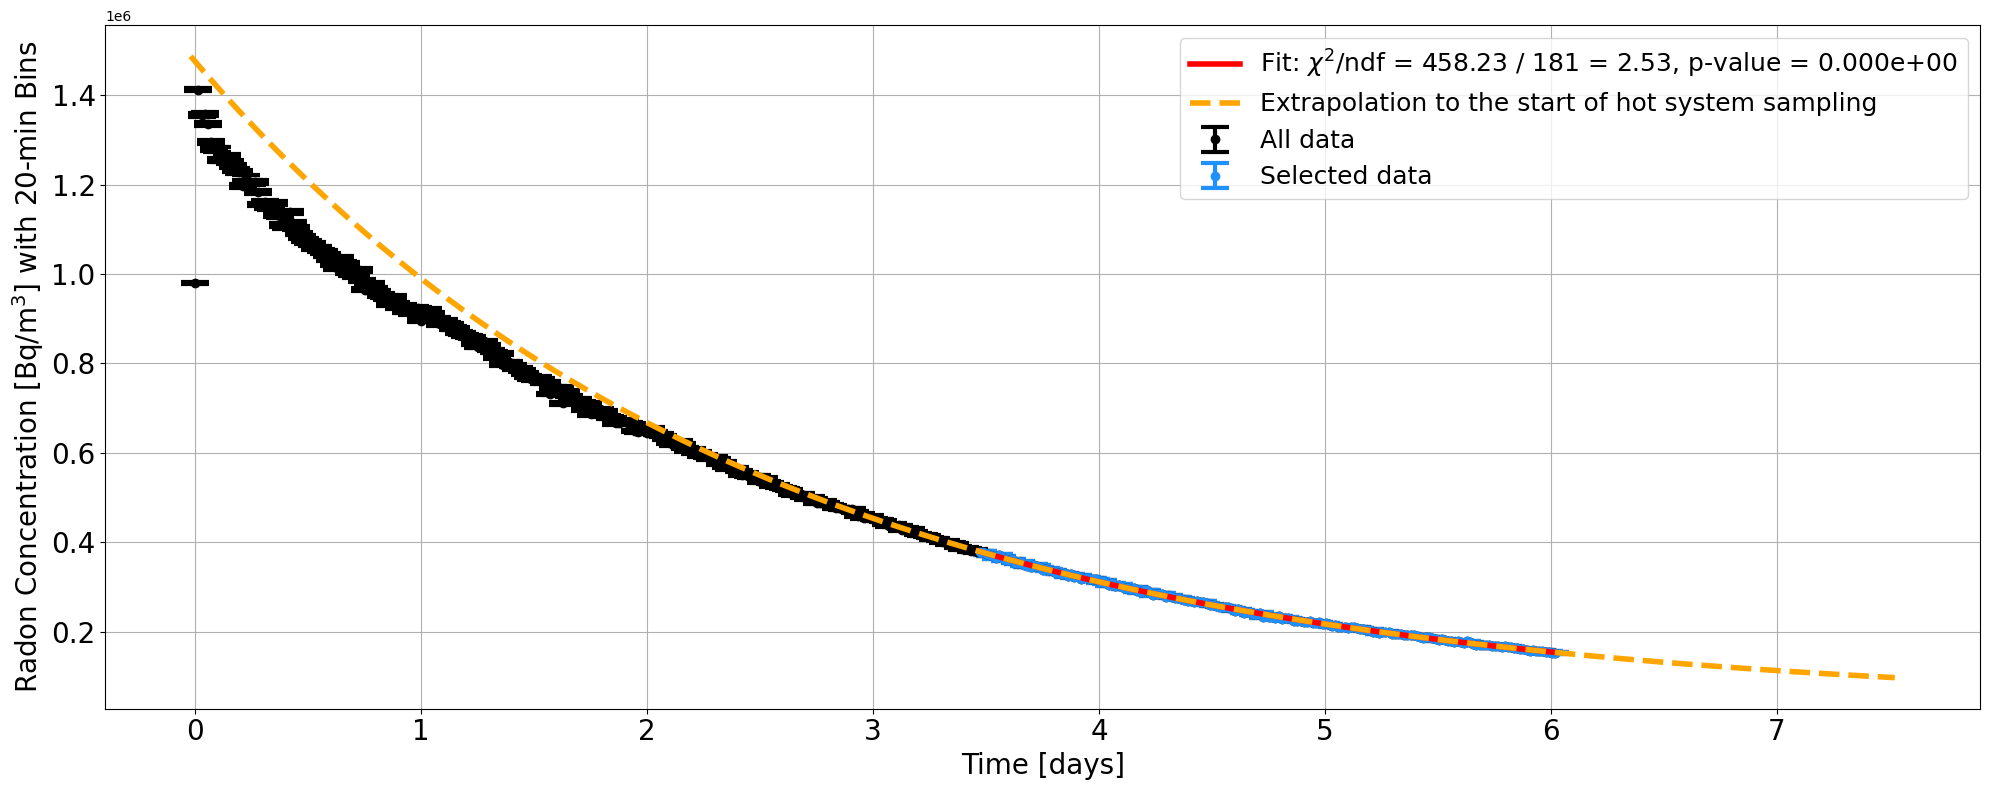

In [12]:
extra_curves=[fit_plot_meta,
             {'x':t_space, 'y':fit_extended_to_start_of_sampling,'color':'orange', 'lw':4, 'ls':'--', 'label':'Extrapolation to the start of hot system sampling'}]

dap.getPlot(df, dfc=dfc, in_days=True, save_plot_as='hotSide_with_selection_withFit_andExtrapolation', extra_curves=extra_curves, measurementName=vs.measurementName)


In [13]:
C_hot_system_initial = fit_extended_to_start_of_sampling[0]
print(f'Initial radon concentration of hot-side system = {C_hot_system_initial:0.2f} Bq/m^3')

Initial radon concentration of hot-side system = 1487294.90 Bq/m^3


### rad7 and tubing leak rate
    Gets rad7 + tubing lambda

In [14]:
df = dap.getData('SDSMT', '240410_Ti_diff_RAD7_and_tubing', binSize_hours=1/3, onlyPo218=True)
dfc = dap.placeCut(df, t_i='2024-04-08 13:29:00', t_f='2024-04-10 13:48:00') # timestamps from logs

All data loaded into a list: [df1, df2, ... ]
sumNumber: 1 1.0
All runs processed.
Columns are:  Index(['DateTime', 'RnConc', 'Uncert_RnConc', 'Counts', 'Uncert_Counts',
       'Temperature', 'Cnts_to_Bqm3', 'Days', 'Seconds', 'Hours'],
      dtype='object')


Measurement folder already exists.
plot saved: Plots/Measurement_5/rad7_and_tubing_with_selection.pdf


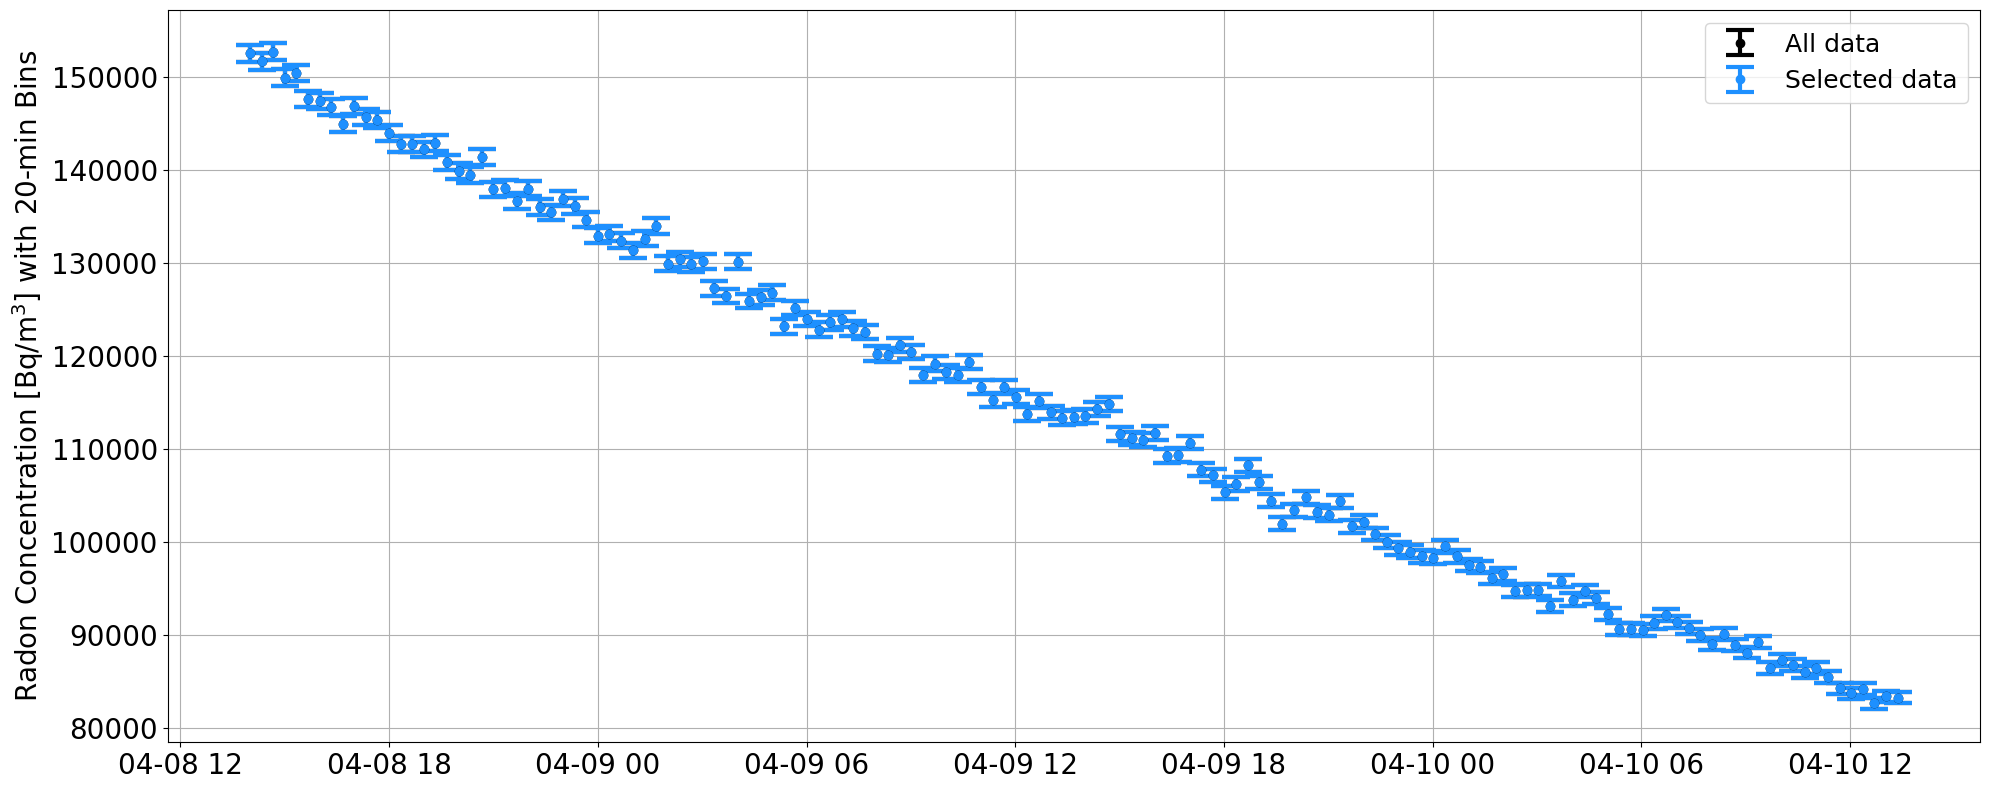

In [15]:
dap.getPlot(df, dfc=dfc, in_days=False, save_plot_as='rad7_and_tubing_with_selection', measurementName=vs.measurementName)

In [16]:
p0 = (max(dfc.RnConc), vs.tau_Rn, 0)
bounds = (0, np.infty)
ret = dap.performFit(dfc.Days, dfc.RnConc, dfc.Uncert_RnConc, p0=p0, bounds=bounds, fitting_function=dap.exponentialFit)


popt = [1.52223494e+05 3.29156084e+00 7.40648460e-13] +/- [6.50736382e+03 1.97196309e-01 6.73619057e+03]
pcov = [[ 4.23457839e+07  1.27550141e+03 -4.38069572e+07]
 [ 1.27550141e+03  3.88863841e-02 -1.32432156e+03]
 [-4.38069572e+07 -1.32432156e+03  4.53762634e+07]]
chi squared / ndf = 305.76 / 140 = 2.18, p-value = 2.232e-14


In [17]:
lamb_rad7_and_tubing = 1 / ret['popt'][1]

Measurement folder already exists.
plot saved: Plots/Measurement_5/hotSide_Rad7_and_tubing_withFit.pdf


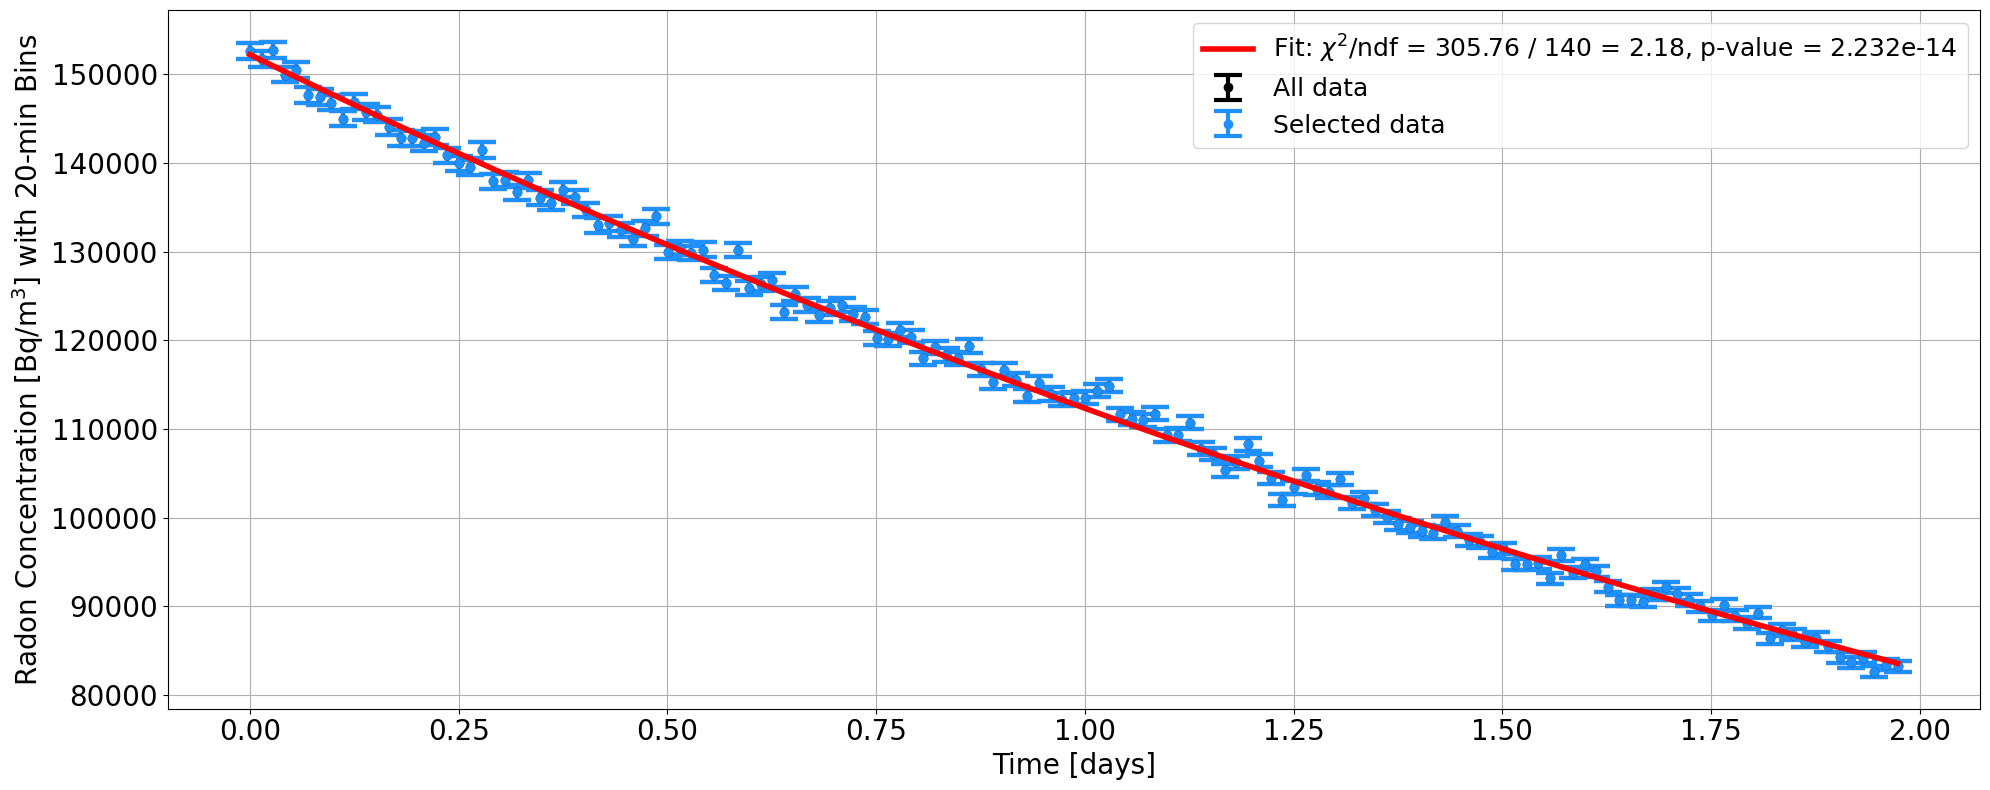

In [18]:
fit_plot_meta = {'x':dfc.Days, 'y':ret['fit'],'color':'r', 'lw':4,'label':'Fit: '+r'$\chi^2$/ndf = '+f"{ret['gof'][0]:0.2f} / {ret['gof'][1]:0.0f} = {ret['gof'][2]:0.2f}, p-value = {ret['gof'][3]:0.3e}"}
extra_curves=[fit_plot_meta]

dap.getPlot(df, dfc=dfc, in_days=True, save_plot_as='hotSide_Rad7_and_tubing_withFit', extra_curves=extra_curves, measurementName=vs.measurementName)

In [19]:
# e^-(lamb_Rn + lamb_rad7 + lamb_tubing + lamb_mebrane) t) = e^(-lamb_hotSide_system t) :: for hot-side system
# e^-(lamb_Rn + lamb_rad7 + lamb_tubing ) t) = e^(-lamb_rad7_and_tubing t) :: for rad7 and tubing
# --> lamb_hotSide_system - lamb_rad7_and_tubing = lamb_membrane

lamb_membrane = (lamb_hot_system - lamb_rad7_and_tubing)

print(f'tau_hotSide_system = {1/lamb_hot_system:0.2f}, tau_rad7_and_tubing = {1/lamb_rad7_and_tubing:0.2f}, tau_membrane = {1/lamb_membrane:0.2f} days')
print(f'lamb_hotSide_system = {lamb_hot_system:0.3f}, lamb_rad7_and_tubing = {lamb_rad7_and_tubing:0.3f}, lamb_membrane = {lamb_membrane:0.3f} 1/days')

tau_hotSide_system = 2.44, tau_rad7_and_tubing = 3.29, tau_membrane = 9.46 days
lamb_hotSide_system = 0.410, lamb_rad7_and_tubing = 0.304, lamb_membrane = 0.106 1/days


### Intial hot side volume concentration
    Gets initial hot side volume concentration

In [20]:
A_system = C_hot_system_initial * vs.Vsys
# A_lost = C_lost * vs.Vrad7

# A_actual = A_system + A_lost

# C_actual = A_actual / vs.Vsys
C_actual = A_system / vs.Vsys

time_between_diffusion_and_hotSide_sampling = (pd.to_datetime(vs.start_of_hot_system_sampling) - pd.to_datetime(vs.start_of_diffusion)).total_seconds() / 86400 # days

C_hotside_volume_initial = C_actual * (vs.Vsys / vs.Vhot) * np.exp(+(vs.lamb_Rn + lamb_membrane) * time_between_diffusion_and_hotSide_sampling)
# C_hotside_volume_initial = np.exp(+(vs.lamb_Rn + lamb_membrane) * time_between_diffusion_and_hotSide_sampling)

print(f'Estimate of initial hot-side volume radon concentration, C_hot  = {C_hotside_volume_initial / 1e6:.5f} MBq/m^3.')
print(f'C_actual = {C_actual :.4f} Bq/m^3, lamb_membrane = {lamb_membrane :.4f}, time between diffusion and hotSide runs = {time_between_diffusion_and_hotSide_sampling :.4f}')

Estimate of initial hot-side volume radon concentration, C_hot  = 40.21027 MBq/m^3.
C_actual = 1487294.9035 Bq/m^3, lamb_membrane = 0.1057, time between diffusion and hotSide runs = 6.0028


### Cold Side Leak Rate
    Gets cold side lambda no source

In [21]:
df = dap.getData('Syracuse', '240410_Si_and_Ti_flushingVolumes', binSize_hours=1/3, onlyPo218=True)
dfc = dap.placeCut(df, t_i='2024-04-06 00:00:00', t_f='2024-04-11 00:00:00') # timestamps from logs

All data loaded into a list: [df1, df2, ... ]
sumNumber: 1 1.0
All runs processed.
Columns are:  Index(['DateTime', 'RnConc', 'Uncert_RnConc', 'Counts', 'Uncert_Counts',
       'Temperature', 'Cnts_to_Bqm3', 'Days', 'Seconds', 'Hours'],
      dtype='object')


Measurement folder already exists.
plot saved: Plots/Measurement_5/Syrcause_no_source_time.pdf


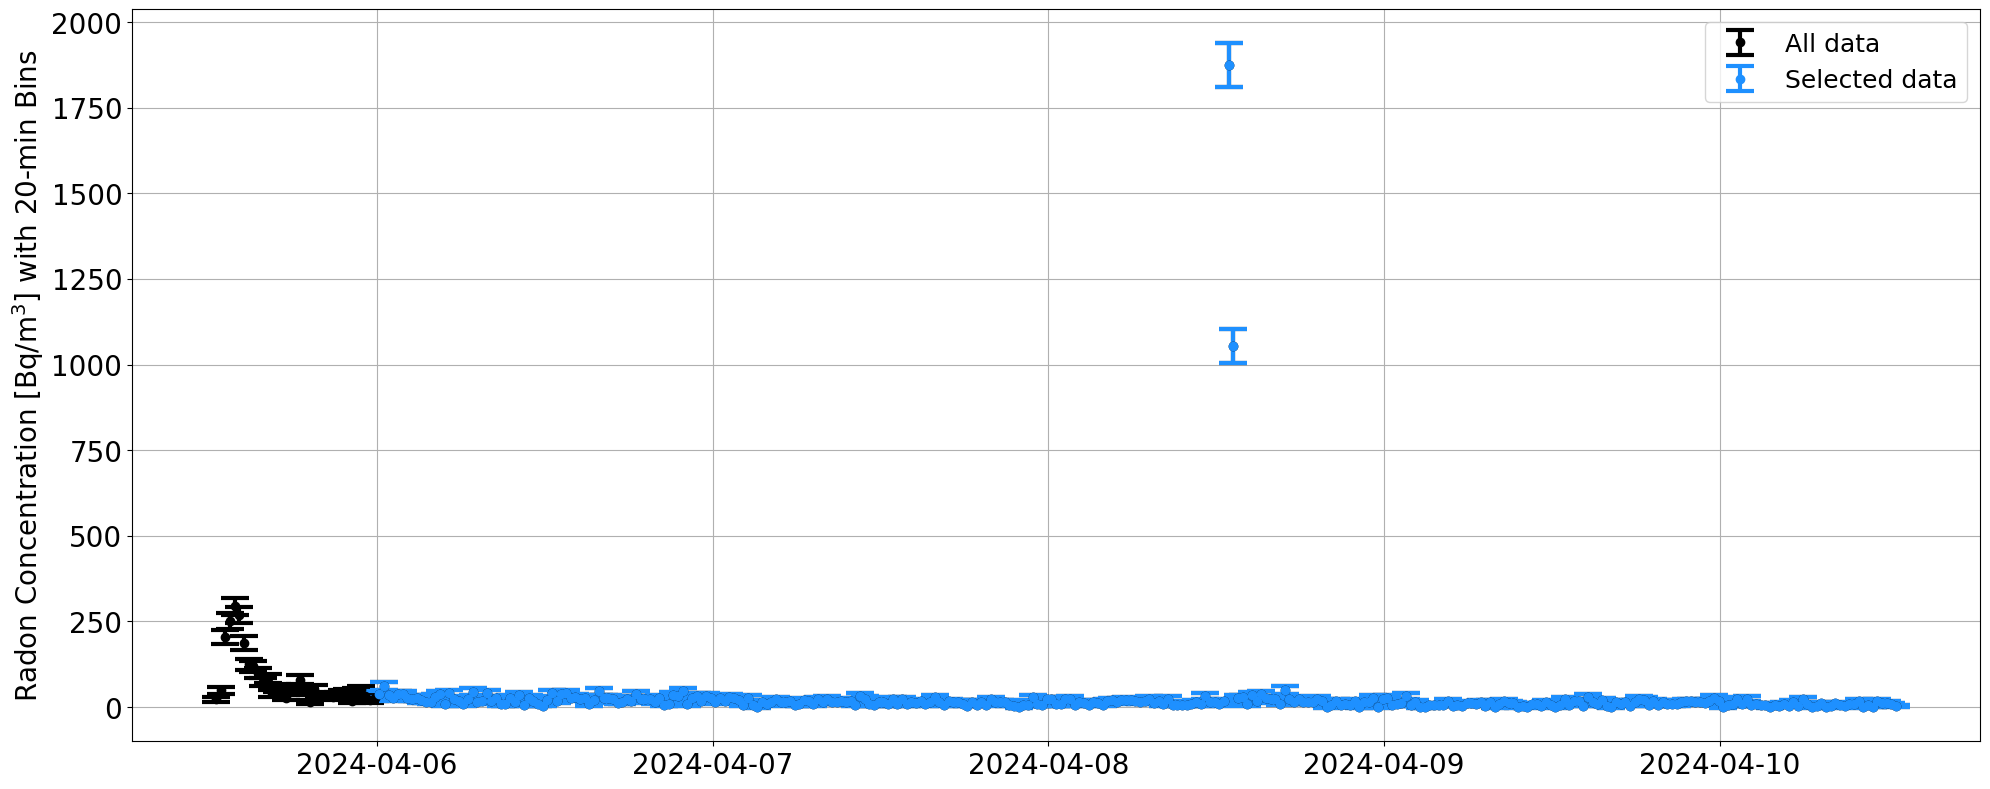

In [22]:
dap.getPlot(df, dfc=dfc, in_days=False, save_plot_as='Syrcause_no_source_time', measurementName=vs.measurementName)

In [23]:
df = dap.getData('4261', '240410_Ti_diff_coldSide_noSource', binSize_hours=1/3, onlyPo218=True)
dfc = dap.placeCut(df, t_i='2024-04-06 00:00:00', t_f='2024-04-11 00:00:00') # timestamps from logs

All data loaded into a list: [df1, df2, ... ]
sumNumber: 1 1.0
All runs processed.
Columns are:  Index(['DateTime', 'RnConc', 'Uncert_RnConc', 'Counts', 'Uncert_Counts',
       'Temperature', 'Cnts_to_Bqm3', 'Days', 'Seconds', 'Hours'],
      dtype='object')


Measurement folder already exists.
plot saved: Plots/Measurement_5/coldSide_no_source.pdf


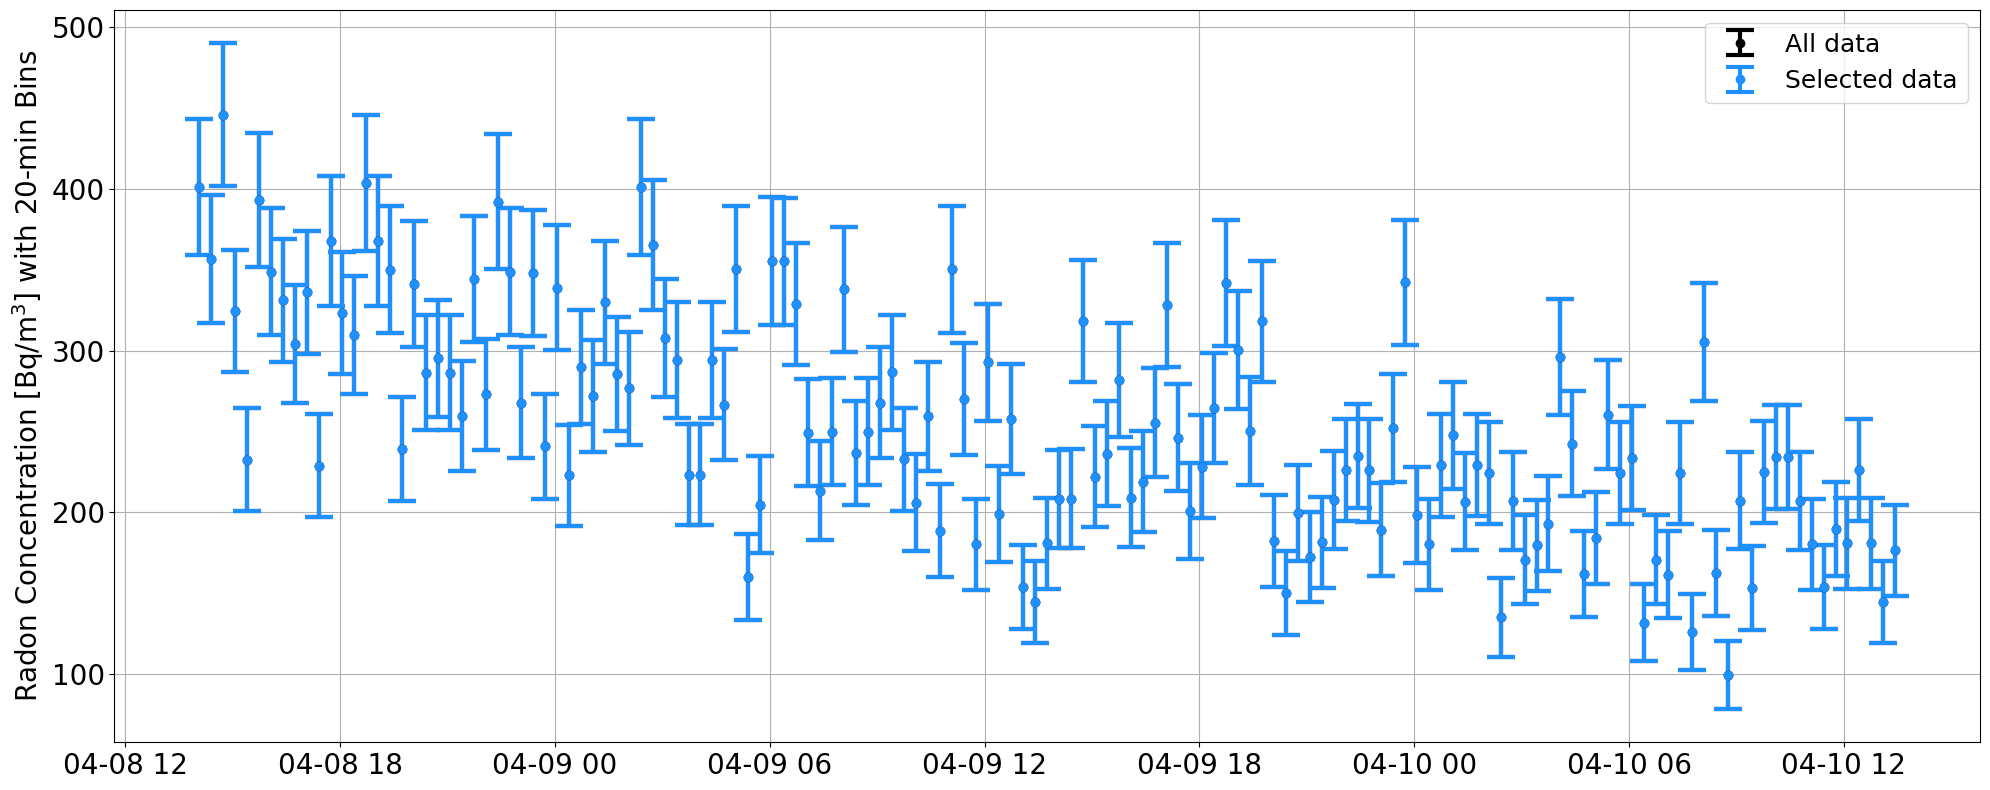

In [24]:
dap.getPlot(df, dfc=dfc, in_days=False, save_plot_as='coldSide_no_source', measurementName=vs.measurementName)

In [25]:
p0 = (max(dfc.RnConc), vs.tau_Rn, 0)
bounds = (0, np.infty)
ret = dap.performFit(dfc.Days, dfc.RnConc, dfc.Uncert_RnConc, p0=p0, bounds=bounds, fitting_function=dap.exponentialFit)

lamb_coldSide_noSource = 1 / ret['popt'][1]


popt = [228.27221069   1.4565384  117.08643757] +/- [53.77210103  0.76544281 62.8774479 ]
pcov = [[ 2.89143885e+03  3.79625210e+01 -3.28653587e+03]
 [ 3.79625210e+01  5.85902690e-01 -4.73349744e+01]
 [-3.28653587e+03 -4.73349744e+01  3.95357345e+03]]
chi squared / ndf = 345.28 / 140 = 2.47, p-value = 0.000e+00


Measurement folder already exists.
plot saved: Plots/Measurement_5/coldSide_noSource_withFit.pdf


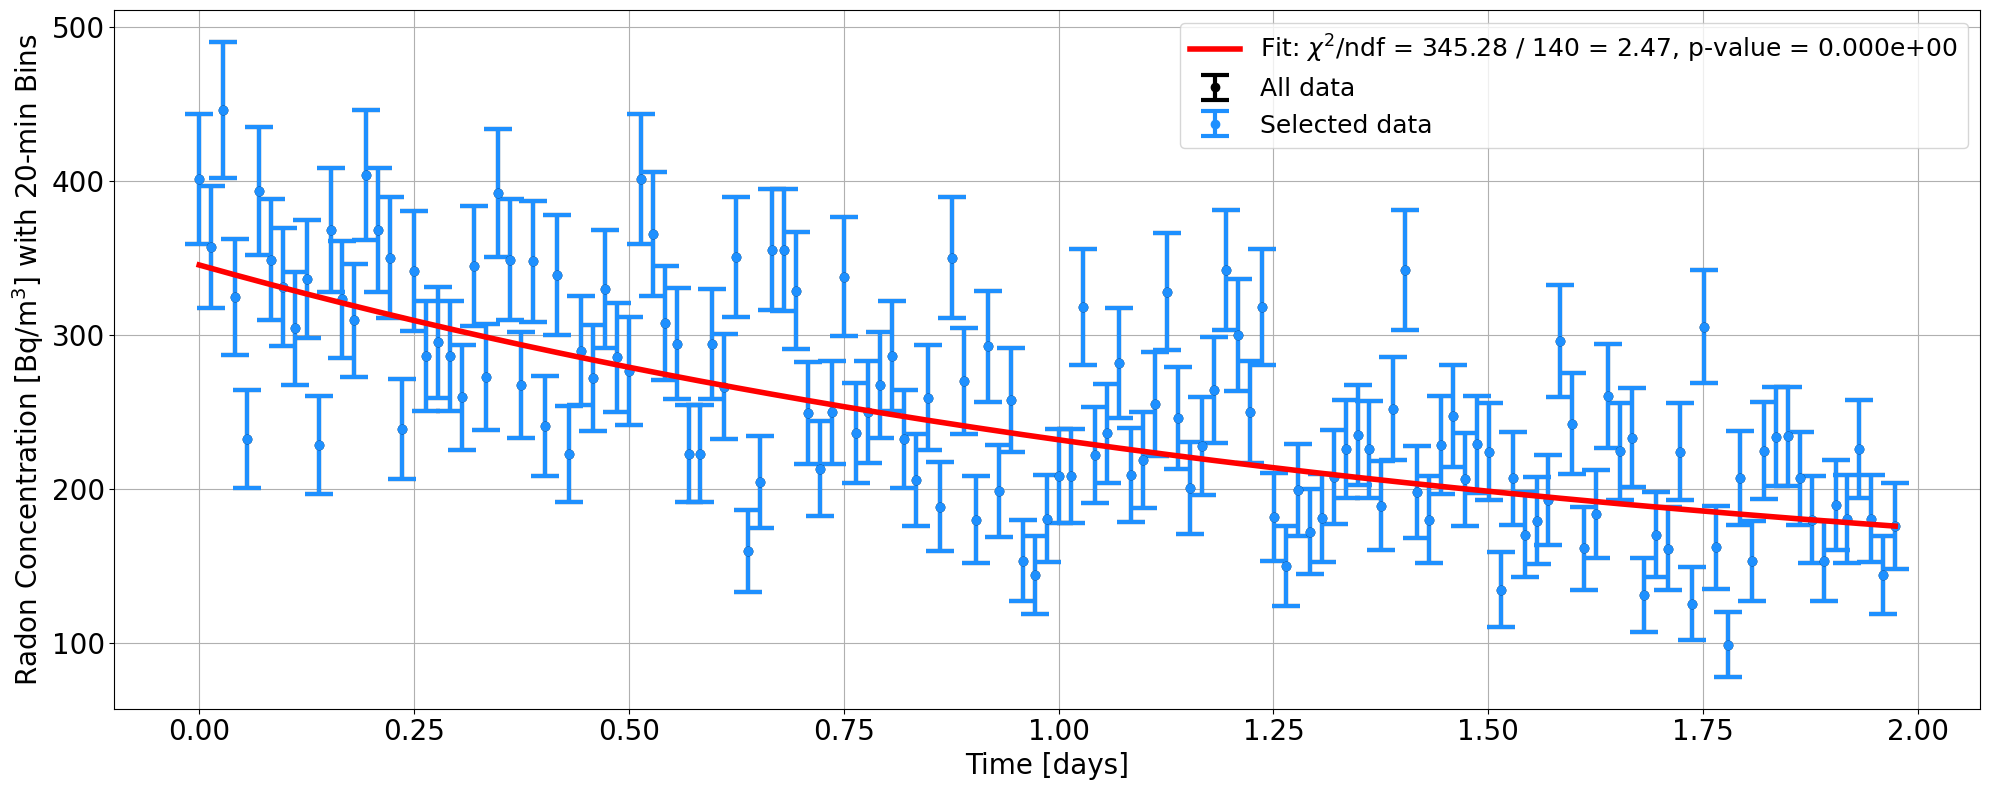

In [26]:
fit_plot_meta = {'x':dfc.Days, 'y':ret['fit'],'color':'r', 'lw':4,'label':'Fit: '+r'$\chi^2$/ndf = '+f"{ret['gof'][0]:0.2f} / {ret['gof'][1]:0.0f} = {ret['gof'][2]:0.2f}, p-value = {ret['gof'][3]:0.3e}"}
extra_curves=[fit_plot_meta]

dap.getPlot(df, dfc=dfc, in_days=True, save_plot_as='coldSide_noSource_withFit', extra_curves=extra_curves, measurementName=vs.measurementName) # xLimits=(0, 7), yLimits=(0, 1200))

In [27]:
print(f'Effective tau for coldside (with no source): {1/lamb_coldSide_noSource:0.2f} days or 1/tau = lambda = {lamb_coldSide_noSource:0.2f} 1/days.')

Effective tau for coldside (with no source): 1.46 days or 1/tau = lambda = 0.69 1/days.


### Perform fit to data to get concentration on cold side
    gets cold side concentration

In [28]:
df = dap.getData('4261', '240408_Ti_diff_coldSide', binSize_hours=1, onlyPo218=True)
dfc = dap.placeCut(df, t_i=vs.start_of_diffusion, t_f=vs.end_of_diffusion) # timestamps from logs

All data loaded into a list: [df1, df2, ... ]
sumNumber: 3 3.0
All runs processed.
Columns are:  Index(['DateTime', 'RnConc', 'Uncert_RnConc', 'Counts', 'Uncert_Counts',
       'Temperature', 'Cnts_to_Bqm3', 'Days', 'Seconds', 'Hours'],
      dtype='object')


Measurement folder already exists.
plot saved: Plots/Measurement_5/coldSide_selection.pdf


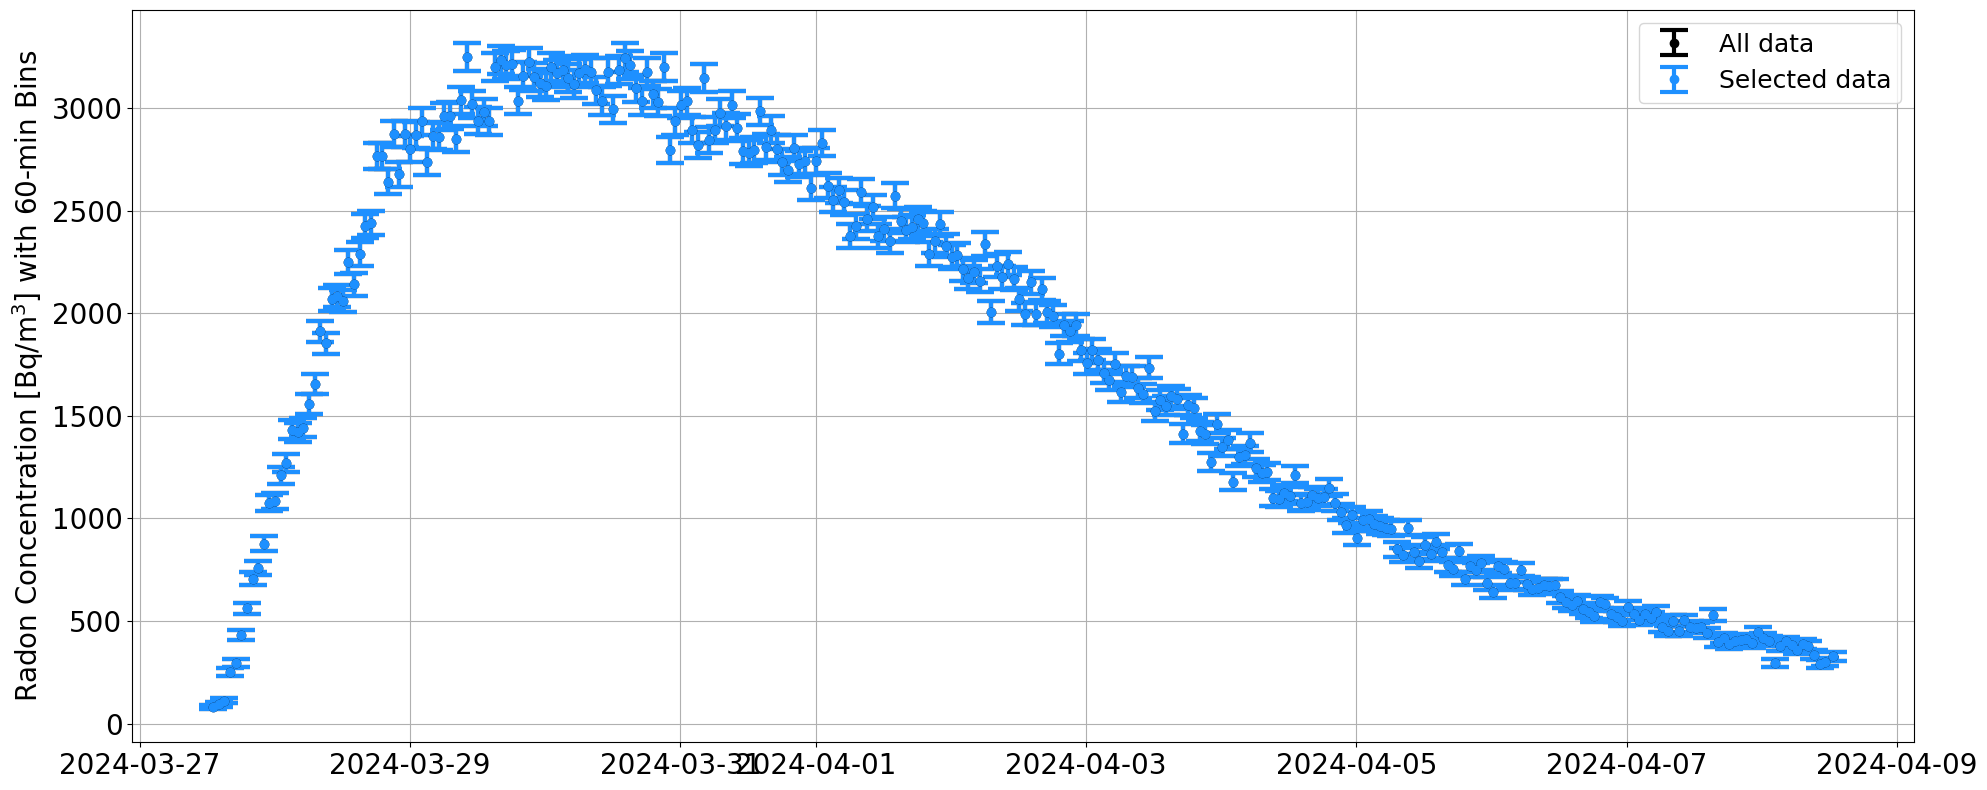

In [29]:
dap.getPlot(df, dfc=dfc, in_days=False, save_plot_as='coldSide_selection', measurementName=vs.measurementName)

In [30]:
dfc.Days = dfc.Days + vs['time_shift_sec']/86400 #  0.5/24 # REVISIT !
dfc.Seconds = dfc.Seconds + vs['time_shift_sec'] #  0.5/24 # REVISIT !

In [35]:
# Update variable dictionary
vs.update({'lambda_': (vs.lamb_Rn + lamb_membrane) / 86400,
            'lambda_rad7':lamb_coldSide_noSource / 86400,
            'tau_cold':1 / lamb_coldSide_noSource,
            'C_H':C_hotside_volume_initial,
            'C_initial':np.mean(dfc.RnConc.iloc[0:3]), # This line might need modified!
            'dfc':dfc # diffusion data for numerical fit
            }) 

In [62]:
# time, C = model_full(vs, minimize_model=False, D_val=5.1371001829e-13, S_val=3.3517369398, tau_cold_val=1.4850424723, verbose=True)
# time, C = model_full(vs, minimize_model=False, D_val=6.21e-13, S_val=2.89, tau_cold_val=1.4850424723, verbose=True)
# time, C = model_full(vs, minimize_model=False, D_val=7.7e-13, S_val=2, tau_cold_val=1.4850424723, verbose=True)
time, C = dap.model_full(vs, minimize_model=False, D_val=4.574e-13, P_val=1.038e-12 , tau_cold_val=1.457, verbose=True)

D = 9.00000e-13 m^2/s, P = 2.00000e-12 m^2/s, tau_cold = 1.45700 days.
D = 9.00000e-13 m^2/s, P = 2.00000e-12 m^2/s, tau_cold = 1.45700 days.
chi squared / ndf = 129254.40 / 285 = 453.52, p-value = 0.000e+00


In [41]:
time, C_fit = dap.model_full(vs, minimize_model=True, p0=(1e-13, 1e-12), verbose=True)

p0 (1e-13, 1e-12)
D = 1.00000e-13 m^2/s, P = 1.00000e-12 m^2/s, tau_cold = 1.45654
D = 1.31623e-13 m^2/s, P = 1.00000e-12 m^2/s, tau_cold = 1.45654
D = 1.00000e-13 m^2/s, P = 1.31623e-12 m^2/s, tau_cold = 1.45654
D = 7.39728e-13 m^2/s, P = -6.26173e-12 m^2/s, tau_cold = 1.45654
D = 1.67607e-13 m^2/s, P = 1.62155e-12 m^2/s, tau_cold = 1.45654
D = 2.20609e-13 m^2/s, P = 1.62155e-12 m^2/s, tau_cold = 1.45654
D = 1.67607e-13 m^2/s, P = 2.13433e-12 m^2/s, tau_cold = 1.45654
D = 2.90685e-13 m^2/s, P = 1.41467e-12 m^2/s, tau_cold = 1.45654
D = 3.82607e-13 m^2/s, P = 1.41467e-12 m^2/s, tau_cold = 1.45654
D = 2.90685e-13 m^2/s, P = 1.86203e-12 m^2/s, tau_cold = 1.45654
D = 5.40172e-13 m^2/s, P = 1.13714e-12 m^2/s, tau_cold = 1.45654
D = 7.10990e-13 m^2/s, P = 1.13714e-12 m^2/s, tau_cold = 1.45654
D = 5.40172e-13 m^2/s, P = 1.49673e-12 m^2/s, tau_cold = 1.45654
D = 1.04761e-12 m^2/s, P = 1.09356e-12 m^2/s, tau_cold = 1.45654
D = 1.37889e-12 m^2/s, P = 1.09356e-12 m^2/s, tau_cold = 1.45654
D = 1.

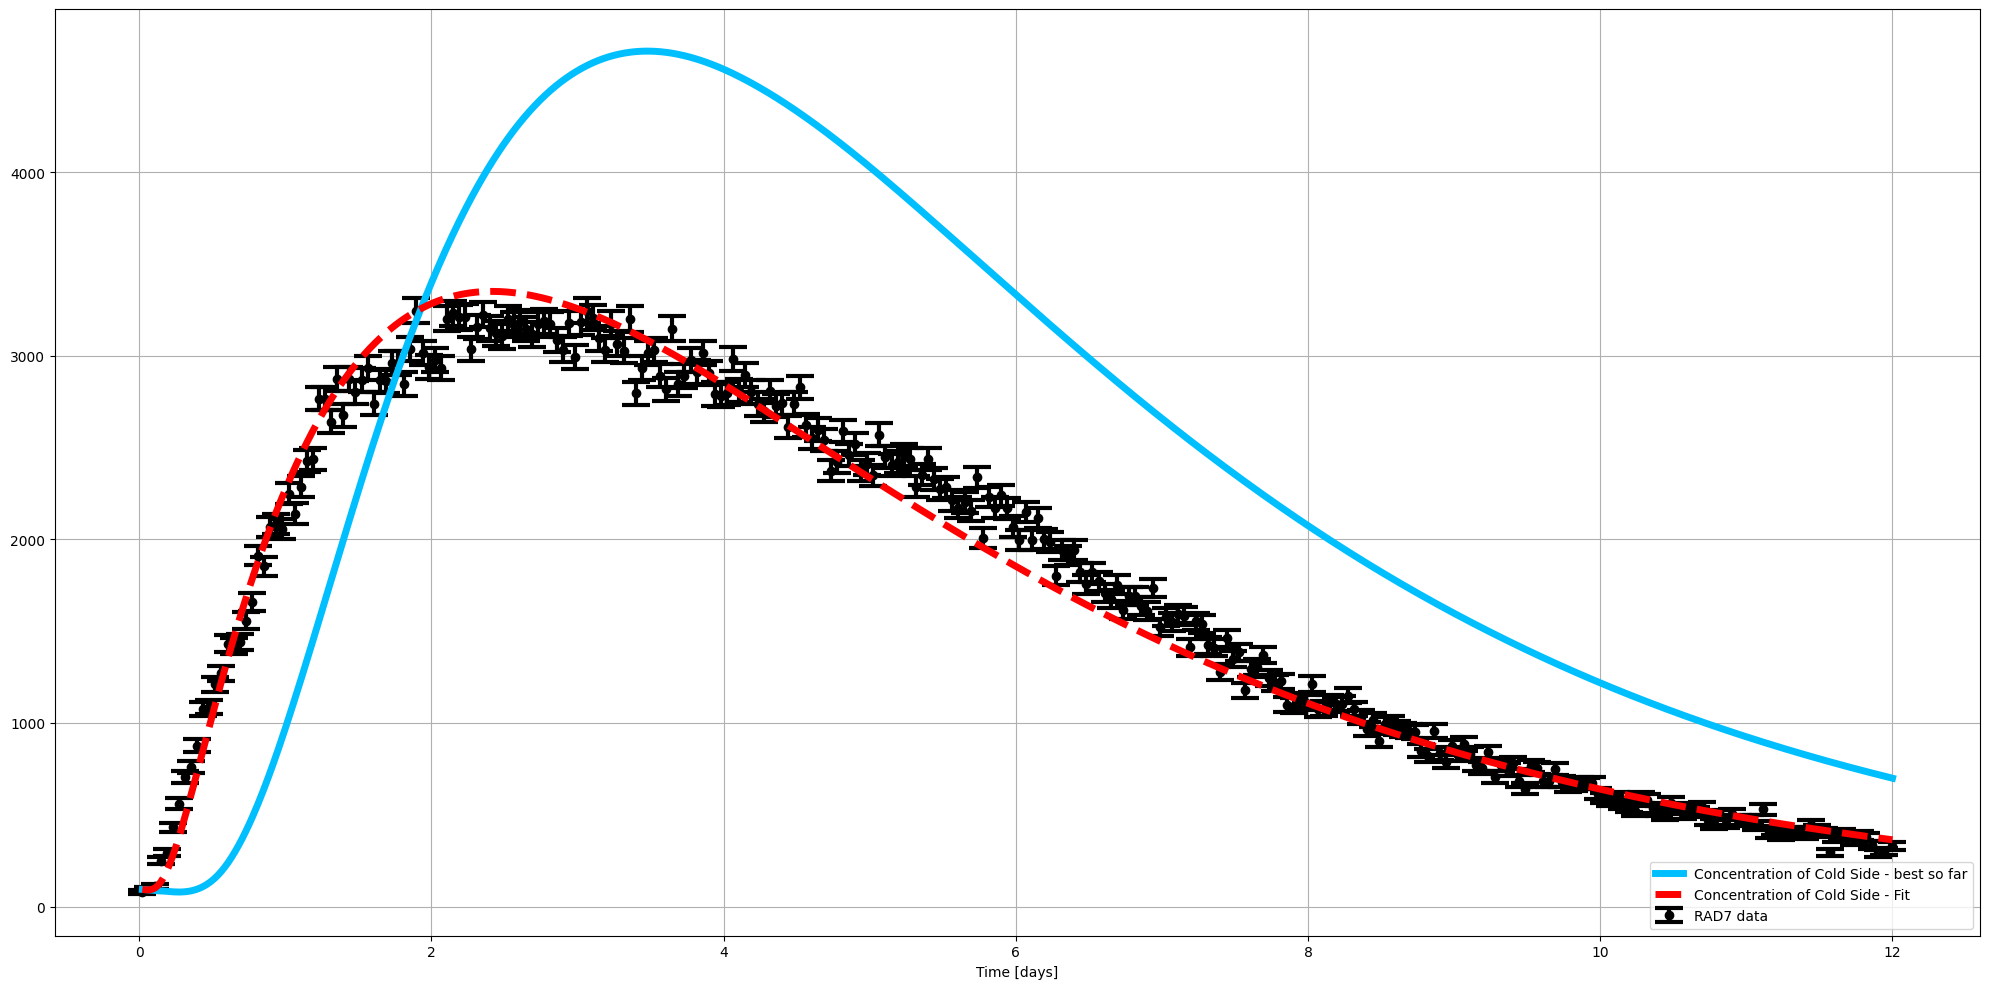

In [63]:
# %matplotlib inline
import matplotlib as mpl
# mpl.rcParams.update(mpl.rc_params_from_file(fname='/home/joseph/.config/matplotlib/matplotlibrc'))

import matplotlib.pyplot as plt

# hotSideScaling = 1


plt.figure(figsize=(20,10))


plt.errorbar(dfc.Days, dfc.RnConc, dfc.Uncert_RnConc, fmt='o', color = 'k', lw=3, capsize=10, alpha = 1, capthick=3, label='RAD7 data')

plt.plot(time/3600/24, C, label="Concentration of Cold Side - best so far", lw=5, color='deepskyblue', zorder=10)

plt.plot(time/3600/24, C_fit, label="Concentration of Cold Side - Fit",ls = '--', lw=5, color='red', zorder=10)

plt.xlabel(r'Time [days]')

plt.legend(loc='lower right')

# plt.xlim(0,1)
# plt.ylim(0,1000)
# plt.yscale("log")

plt.grid()
plt.tight_layout()

# fileName = '240227_diff_coldSide_raw'
# savePath = 'Plots/'
plt.savefig("cold_side_results_with_fit.pdf", format = "pdf", bbox_inches = "tight")

plt.show()